In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time

In [3]:
from dataprep.helperfunctions import *
from dataprep.memory_helperfunctions import prepare_data_f_memory

In [4]:
from simulation.simulation_pipeline import *
from simulation.simulation_helpers import *

In [5]:
import pomegranate

In [6]:
from experiment.DoE import *

# Make a design table

In [7]:
run_settings = {"process_entropy":["min_entropy","med_entropy","max_entropy"], #,"med_entropy","max_entropy","med_entropy","max_entropy"
                "number_of_traces":[100],
                "statespace_size":[5,10],
                "process_type":["memoryless","memory"],        #"memoryless","memory" 
                
                #order of HOMC
                "process_memory":[4],
                
                #number of transitions
                "med_ent_n_transitions":[3,5],
                                
                #lambda parameter of inter-arrival times
                "inter_arrival_time":[1.5],
                
                #lambda parameter of process noise
                "process_stability_scale":[0.1],
                
                #probability of getting an agent
                "resource_availability_p":[0.5],
                #number of agents
                "resource_availability_n":[3],
                #waiting time in days, when no agent is available
                "resource_availability_m":[0.041],
                
                #variation between activity durations
                "activity_duration_lambda_range":[1],
                
                #business hours definition: when can cases be processed?
                "Deterministic_offset_W":["weekdays"], #weekdays, all-week
                #time-unit for a full week: days = 7, hrs = 24*7, etc.
                "Deterministic_offset_u":[7],
                
                #run full model pipeline from simulated data
                "model_pipeline":[False],
                
                #repeat the experiment
                "num_replications":list(range(0,1))
               }


# Generate a full factorial:
df=build_full_fact(run_settings)#[0:2]

# Recode the string factor levels (recoding from natural number to string)
df = fix_label_values(df, run_settings, variables = ["process_entropy",
                                                     "process_type",
                                                     "Deterministic_offset_W",
                                                     "model_pipeline"])
df = df.drop("Name_fix",axis=1)
# Important variables
df["RUN"] = df.index + 1
df["Done"] = 0
df["Failure"] = 0

#change types and save
df.statespace_size = df.statespace_size.astype(int)
df.to_csv("results/design_table.csv",index=False)
df

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,resource_availability_m,activity_duration_lambda_range,Deterministic_offset_W,Deterministic_offset_u,model_pipeline,num_replications,RUN,Done,Failure
0,min_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,1,0,0
1,med_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,2,0,0
2,max_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,3,0,0
3,min_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,4,0,0
4,med_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,5,0,0
5,max_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,6,0,0
6,min_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,7,0,0
7,med_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,8,0,0
8,max_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,9,0,0
9,min_entropy,100.0,10,memory,4.0,3.0,1.5,0.1,0.5,3.0,0.041,1.0,weekdays,7.0,False,0.0,10,0,0


In [8]:
#df = df.loc[:1]
#df

# Perform the experiments

In [9]:
results = []

for run in df.index:
    print(run)
    
    start_time = time.time()
    
    """
    Settings from experiments
    """
    curr_settings = df.loc[run]
    
    """
    settings for the simulation
    """
    
    SIM_SETTINGS = {"save_eventlog":1, #0 = no, 1 = yes...
                
                "statespace_size":make_D(int(curr_settings["statespace_size"])),

                "number_of_traces":int(curr_settings["number_of_traces"]),  

                "process_entropy":curr_settings["process_entropy"],

                "process_type":curr_settings["process_type"],                

                "process_memory":int(curr_settings["process_memory"]),          
                    
                # desired max number of possible transitions in P. 
                # NOTE: This can maximally be the number of states, and should be higher than 2
                "med_ent_n_transitions":int(curr_settings["med_ent_n_transitions"]),
                    
                #lambda parameter of inter-arrival times
                "time_settings":{"inter_arrival_time":float(curr_settings["inter_arrival_time"]), 
                                 
                                #lambda parameter of process noise
                                "process_stability_scale":float(curr_settings["process_stability_scale"]),
                                 
                                #probability of getting an agent
                                "resource_availability_p":float(curr_settings["resource_availability_p"]),                          
                                #waiting time in days, when no agent is available      
                                "resource_availability_n":int(curr_settings["resource_availability_n"]),
                                #waiting time in days, when no agent is available
                                "resource_availability_m":float(curr_settings["resource_availability_m"]), 
                                 
                                #variation between activity durations
                                "activity_duration_lambda_range":float(curr_settings["activity_duration_lambda_range"]),

                                #time-unit for a full week: days = 7, hrs = 24*7, etc.
                                "Deterministic_offset_W":make_workweek(curr_settings["Deterministic_offset_W"]),

                                "Deterministic_offset_u":int(curr_settings["Deterministic_offset_u"])},
                #offset for the timestamps in days from 1970
                "datetime_offset":53,
                #run is the seed
                "run":run}

    # generate the log
    log = Generate_eventlog(SIM_SETTINGS)
    #log.to_csv("results/"+str(run)+"log.csv",index=False)
    
    # log simulated log characteristics
    curr_settings["simuation_time_sec"] = time.time() - start_time
    curr_settings["num_traces"] = len(log.caseid.unique())
    curr_settings["num_events"] = len(log)
    
    variants = []
    tracelengths = []
    for traceid in log.caseid.unique():
        trace = log.loc[log.caseid == traceid]
        #tracelen
        tracelen = len(trace)
        tracelengths.append(tracelen)
        #variant
        sequence = ""
        sequence = sequence.join(trace.activity.tolist())
        variants.append(sequence)
        
    n_variants = len(set(variants))       
    
    curr_settings["num_variants"] = n_variants
    
    curr_settings["avg_tracelen"] = np.mean(tracelengths)
    curr_settings["min_tracelen"] = np.min(tracelengths)
    curr_settings["max_tracelen"] = np.max(tracelengths)
    
    

    # run a machine learning pipeline as well?
    if curr_settings["model_pipeline"] == True:
        """
        Prepare data for modelling
        """
        input_data = prepare_data_f_memory(log)

        """
        Train a model
        """
        # X: 
        input_data["x_train"]
        input_data["x_test"]

        # Y:
        input_data["y_test"]
        input_data["y_test"]

        """
        Evaluate the model
        """

    
        """
        Store the results
        """
        curr_settings["RES_num_events"] = len(log)
        
    #append
    #curr_settings = pd.DataFrame(curr_settings.T)
    #curr_settings.index = [run]
    results.append(curr_settings)
#store results
results = pd.DataFrame(results)
results.to_csv("results/experiments.csv",index=False)  

0
traces: 100
events: 500
ids: 100
1
traces: 100
events: 340
ids: 100
2
traces: 100
events: 531
ids: 100
3
traces: 100
events: 1000
ids: 100
4
traces: 100
events: 1155
ids: 100
5
traces: 100
events: 1098
ids: 100
6
traces: 100
events: 500
ids: 100
7
generated traces: 100
traces: 100
events: 721
ids: 100
8
generated traces: 100
traces: 100
events: 622
ids: 100
9
traces: 100
events: 1000
ids: 100
10
generated traces: 100
traces: 100
events: 832
ids: 100
11
generated traces: 100
traces: 100
events: 977
ids: 100
12
traces: 100
events: 500
ids: 100
13
traces: 100
events: 388
ids: 100
14
traces: 100
events: 568
ids: 100
15
traces: 100
events: 1000
ids: 100
16
traces: 100
events: 787
ids: 100
17
traces: 100
events: 1203
ids: 100
18
traces: 100
events: 500
ids: 100
19
generated traces: 100
traces: 100
events: 820
ids: 100
20
generated traces: 100
traces: 100
events: 582
ids: 100
21
traces: 100
events: 1000
ids: 100
22
generated traces: 100
traces: 100
events: 1167
ids: 100
23
generated traces:

In [10]:
results

,process_entropy,number_of_traces,statespace_size,process_type,process_memory,med_ent_n_transitions,inter_arrival_time,process_stability_scale,resource_availability_p,resource_availability_n,...,RUN,Done,Failure,simuation_time_sec,num_traces,num_events,num_variants,avg_tracelen,min_tracelen,max_tracelen
0,min_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,1,0,0,0.109266,100,500,1,5.00,5,5
1,med_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,2,0,0,0.090394,100,340,53,3.40,1,18
2,max_entropy,100.0,5,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,3,0,0,0.112743,100,531,79,5.31,1,28
3,min_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,4,0,0,0.167790,100,1000,1,10.00,10,10
4,med_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,5,0,0,0.176317,100,1155,89,11.55,1,61
5,max_entropy,100.0,10,memoryless,4.0,3.0,1.5,0.1,0.5,3.0,...,6,0,0,0.174827,100,1098,92,10.98,1,50
6,min_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,7,0,0,0.106287,100,500,1,5.00,5,5
7,med_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,8,0,0,3.903366,100,721,81,7.21,1,36
8,max_entropy,100.0,5,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,9,0,0,6.500869,100,622,79,6.22,1,41
9,min_entropy,100.0,10,memory,4.0,3.0,1.5,0.1,0.5,3.0,...,10,0,0,0.349653,100,1000,1,10.00,10,10


In [11]:
#log.to_csv("log.csv",index=False)
log.head(10)

,caseid,activity,activity_no,y_acc_sum,z_t,n_t,q_t,h_t,b_t,s_t,v_t,u_t,starttime,endtime,arrival_datetime,start_datetime,end_datetime,start_day,start_hour
0,0,k,1,0,3.60759,3.607590,3.702149,0.041,0.053560,0.000000,0.015263,0.109822,3.702149,3.717412,2023-01-05 08:34:55,2023-01-05 10:51:05,2023-01-05 11:13:04,Thursday,10
1,0,h,2,0,3.60759,3.717412,3.897989,0.082,0.098577,0.000000,0.024909,0.205486,3.897989,3.922898,2023-01-05 08:34:55,2023-01-05 15:33:06,2023-01-05 16:08:58,Thursday,15
2,0,b,3,0,3.60759,3.922898,3.972841,0.041,0.008943,0.000000,1.191495,1.241438,3.972841,5.164336,2023-01-05 08:34:55,2023-01-05 17:20:53,2023-01-06 21:56:38,Thursday,17
3,0,f,4,0,3.60759,5.164336,5.271647,0.082,0.025311,2.228353,1.507944,3.843608,7.500000,9.007944,2023-01-05 08:34:55,2023-01-09 06:00:00,2023-01-10 18:11:26,Monday,6
4,0,f,5,0,3.60759,9.007944,2.106586,0.041,0.057642,0.393414,0.055618,0.547675,9.500000,9.555618,2023-01-05 08:34:55,2023-01-11 06:00:00,2023-01-11 07:20:05,Wednesday,6
5,0,i,6,0,3.60759,9.555618,2.587834,0.000,0.032216,0.000000,1.841332,1.873548,9.587834,11.429166,2023-01-05 08:34:55,2023-01-11 08:06:28,2023-01-13 04:17:59,Wednesday,8
6,0,d,7,0,3.60759,11.429166,4.516347,0.000,0.087181,0.000000,0.785693,0.872874,11.516347,12.302040,2023-01-05 08:34:55,2023-01-13 06:23:32,2023-01-14 01:14:56,Friday,6
7,0,b,8,0,3.60759,12.302040,5.669456,0.041,0.326416,1.830544,0.009350,2.207310,14.500000,14.509350,2023-01-05 08:34:55,2023-01-16 06:00:00,2023-01-16 06:13:27,Monday,6
8,0,g,9,0,3.60759,14.509350,0.599498,0.041,0.049148,0.000000,1.220349,1.310497,14.599498,15.819847,2023-01-05 08:34:55,2023-01-16 08:23:16,2023-01-17 13:40:34,Monday,8
9,0,c,10,0,3.60759,15.819847,2.191139,0.041,0.330293,0.308861,0.055613,0.735767,16.500000,16.555613,2023-01-05 08:34:55,2023-01-18 06:00:00,2023-01-18 07:20:04,Wednesday,6


<AxesSubplot:xlabel='start_day'>

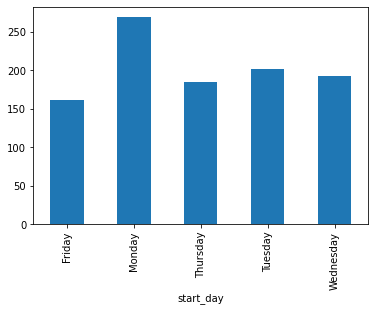

In [12]:
log['caseid'].groupby(log['start_day']).count().plot(kind="bar")

In [13]:
log.start_datetime

0      2023-01-05 10:51:05
1      2023-01-05 15:33:06
2      2023-01-05 17:20:53
3      2023-01-09 06:00:00
4      2023-01-11 06:00:00
               ...        
1004   2023-07-03 06:00:00
1005   2023-07-03 15:26:26
1006   2023-07-04 06:00:00
1007   2023-07-04 10:27:38
1008   2023-07-05 06:00:00
Name: start_datetime, Length: 1009, dtype: datetime64[ns]

In [14]:
(1/24)*3.25

0.13541666666666666

# Inspect example data

In [15]:
log

,caseid,activity,activity_no,y_acc_sum,z_t,n_t,q_t,h_t,b_t,s_t,v_t,u_t,starttime,endtime,arrival_datetime,start_datetime,end_datetime,start_day,start_hour
0,0,k,1,0,3.607590,3.607590,3.702149,0.041,0.053560,0.000000,0.015263,0.109822,3.702149,3.717412,2023-01-05 08:34:55,2023-01-05 10:51:05,2023-01-05 11:13:04,Thursday,10
1,0,h,2,0,3.607590,3.717412,3.897989,0.082,0.098577,0.000000,0.024909,0.205486,3.897989,3.922898,2023-01-05 08:34:55,2023-01-05 15:33:06,2023-01-05 16:08:58,Thursday,15
2,0,b,3,0,3.607590,3.922898,3.972841,0.041,0.008943,0.000000,1.191495,1.241438,3.972841,5.164336,2023-01-05 08:34:55,2023-01-05 17:20:53,2023-01-06 21:56:38,Thursday,17
3,0,f,4,0,3.607590,5.164336,5.271647,0.082,0.025311,2.228353,1.507944,3.843608,7.500000,9.007944,2023-01-05 08:34:55,2023-01-09 06:00:00,2023-01-10 18:11:26,Monday,6
4,0,f,5,0,3.607590,9.007944,2.106586,0.041,0.057642,0.393414,0.055618,0.547675,9.500000,9.555618,2023-01-05 08:34:55,2023-01-11 06:00:00,2023-01-11 07:20:05,Wednesday,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,99,g,13,0,171.369896,180.313800,5.598694,0.041,0.243893,1.901306,0.200737,2.386936,182.500000,182.700737,2023-06-22 02:52:39,2023-07-03 06:00:00,2023-07-03 10:49:03,Monday,6
1005,99,e,14,0,171.369896,182.700737,0.893365,0.123,0.069628,0.000000,0.346223,0.538852,182.893365,183.239588,2023-06-22 02:52:39,2023-07-03 15:26:26,2023-07-03 23:45:00,Monday,15
1006,99,j,15,0,171.369896,183.239588,1.355994,0.041,0.075406,0.144006,0.005329,0.265741,183.500000,183.505329,2023-06-22 02:52:39,2023-07-04 06:00:00,2023-07-04 06:07:40,Tuesday,6
1007,99,f,16,0,171.369896,183.505329,1.685863,0.082,0.098534,0.000000,0.617713,0.798247,183.685863,184.303576,2023-06-22 02:52:39,2023-07-04 10:27:38,2023-07-05 01:17:08,Tuesday,10


In [16]:
log['arrival_datetime'].describe()

count                    1009
unique                    100
top       2023-06-19 16:25:05
freq                       44
first     2023-01-05 08:34:55
last      2023-06-22 02:52:39
Name: arrival_datetime, dtype: object

<AxesSubplot:xlabel='arrival_datetime'>

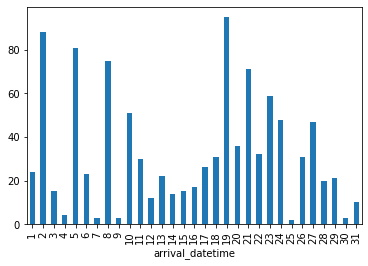

In [17]:
log['caseid'].groupby(log['arrival_datetime'].dt.day).count().plot(kind="bar")

<AxesSubplot:xlabel='arrival_datetime'>

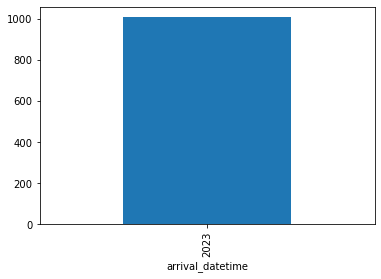

In [18]:
log['caseid'].groupby(log['arrival_datetime'].dt.year).count().plot(kind="bar") #dayofyear